In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import shutil, os

In [66]:
def read_images(folder):
    files = sorted(os.listdir(folder), key=len)
    images = None
    file_names = np.array([])
    for i, file_name in enumerate(tqdm(files)):
        im = cv2.imread(os.path.join(folder, file_name))
        if images is None:
            images = np.empty((len(files), im.shape[0], im.shape[1], im.shape[2]))

        file_names = np.append(file_names, file_name)
        images[i] = im
    return images, file_names

def remove_bad_images(images):
    diff_thresh = 50
    diff1 = len(np.argwhere(cv2.absdiff(images[0], images[1]) > diff_thresh))
    diff2 = len(np.argwhere(cv2.absdiff(images[1], images[2]) > diff_thresh))
    filtered_indexes = []
    for i, image in enumerate(tqdm(images[2:-1])):
        sub = cv2.absdiff(images[i+3], image)
        diff3 = len(np.argwhere(sub > diff_thresh))
        #print(diff1,diff2,diff3)

        if diff1 < diff2 and diff1 < diff3 and diff2 < diff3 and i+1 not in filtered_indexes:
            if len(filtered_indexes) == 0 or (filtered_indexes[len(filtered_indexes)-1] != i and filtered_indexes[len(filtered_indexes)-1] != i+2):
                filtered_indexes.append(i+1)
        elif diff2 <= diff1 and diff2 <= diff3 and i+2 not in filtered_indexes:
            if len(filtered_indexes) == 0 or (filtered_indexes[len(filtered_indexes)-1] != i+1 and filtered_indexes[len(filtered_indexes)-1] != i+3):
                filtered_indexes.append(i+2)
                diff3 = -1
                diff2 = -1

        diff1 = diff2
        diff2 = diff3

    return filtered_indexes

def to_gray(images):
    gray_images = np.empty((images.shape[0], images.shape[1], images.shape[2]))
    for i, image in enumerate(images):
        gray_images[i] = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_BGR2GRAY)
    return gray_images

# Took from algorithm described in https://github.com/sjnarmstrong/gray-code-structured-light/
def get_direct_indirect(images):
    black = images[0]
    white = images[1]

    pattern_len = (len(images) - 2) / 4
    horizontal_ids = np.array([2*pattern_len - 2, 2*pattern_len - 4, 2*pattern_len - 6, 4*pattern_len - 2, 4*pattern_len - 4, 4*pattern_len - 6], dtype=np.uint8)
    vertical_ids = np.array([1, 3, 5, 2*pattern_len + 1, 2*pattern_len + 3, 2*pattern_len + 5], dtype=np.uint8)
    
    b_inv = white / (white + black)
    
    remaining_images = images[2:]
    L_max = np.max(remaining_images[horizontal_ids], axis=0)
    L_min = np.min(remaining_images[vertical_ids], axis=0)

    L_d = (L_max - L_min) * b_inv
    L_g = 2.0 * (L_max - L_d) * b_inv

    return L_d, L_g

# Took from algorithm described in https://github.com/sjnarmstrong/gray-code-structured-light/
def get_is_lit(images, L_d, L_g, eps=5, m=15):
    pattern_len = int((len(images) - 2) / 4)
    pattern_images = images[2:]
    normal_patterns = pattern_images[:pattern_len*2]
    inverse_patterns = pattern_images[pattern_len*2:]

    horizontal_ids = [2*i for i in range(pattern_len)]
    vertical_ids = [2*i + 1 for i in range(pattern_len)]

    h_norm = normal_patterns[horizontal_ids]
    v_norm = normal_patterns[vertical_ids]
    h_inv = inverse_patterns[horizontal_ids]
    v_inv = inverse_patterns[vertical_ids]

    h_codes = np.zeros(h_norm.shape, dtype=np.int8) - 1
    v_codes = np.zeros(v_norm.shape, dtype=np.int8) - 1

    L_d = np.repeat(L_d[np.newaxis, :, :], pattern_len, axis=0)
    L_g = np.repeat(L_g[np.newaxis, :, :], pattern_len, axis=0)

    # Set codes
    h_codes[np.where(L_d < m)] = -1
    v_codes[np.where(L_d < m)] = -1

    h_codes[np.where((L_d > (L_g + eps)) & (h_norm > (h_inv + eps)))] = 1
    v_codes[np.where((L_d > (L_g + eps)) & (v_norm > (v_inv + eps)))] = 1

    h_codes[np.where((L_d > (L_g + eps)) & ((h_norm + eps) < h_inv))] = 0
    v_codes[np.where((L_d > (L_g + eps)) & ((v_norm + eps) < v_inv))] = 0

    h_codes[np.where(((h_norm + eps) < L_d) & (h_inv > (L_g + eps)))] = 0
    v_codes[np.where(((v_norm + eps) < L_d) & (v_inv > (L_g + eps)))] = 0

    h_codes[np.where((h_norm > (L_g + eps)) & ((h_inv + eps) < L_d))] = 1
    v_codes[np.where((v_norm > (L_g + eps)) & ((v_inv + eps) < L_d))] = 1
    
    h_pixels = np.array([gray_to_decimal(h_codes[:, y, x])  for y in range(0, h_codes.shape[1]) for x in range(0, h_codes.shape[2])]).reshape((h_codes.shape[1], h_codes.shape[2]))
    v_pixels = np.array([gray_to_decimal(np.flip(v_codes[:, y, x]))  for y in range(0, v_codes.shape[1])for x in range(0, v_codes.shape[2])] ).reshape((v_codes.shape[1], v_codes.shape[2]))

    # np.save('./h_pixels.npy', h_pixels)
    # np.save('./v_pixels.npy', v_pixels)
    return h_pixels, v_pixels

# https://stackoverflow.com/a/72028021
def gray_decode(n):
    m = n >> 1
    while m:
        n ^= m
        m >>= 1
    return n

def gray_to_decimal(gray_code_list):
    gray_code_list = [str(gray_code_list[i]) for i in range(0, len(gray_code_list))]
    gray_code_str = ''.join(gray_code_list)
    if '-1' in gray_code_str:
        return -1
    
    gray_code_binary = int(gray_code_str, 2)
    return gray_decode(gray_code_binary)

def decode_images(images):
    L_d, L_g = get_direct_indirect(images)
    return get_is_lit(images, L_d, L_g)

In [13]:
filtered_folder = './data/recordings/record_1_filtered'
images, file_names = read_images(filtered_folder)
gray_images = to_gray(images)

100%|██████████| 46/46 [00:01<00:00, 44.02it/s]


In [64]:
h_pixels, v_pixels = decode_images(gray_images)

In [67]:
h_pixels = np.load('h_pixels_screen.npy')
v_pixels = np.load('v_pixels_screen.npy')

In [2]:
def arr_creat(upperleft, upperright, lowerleft, lowerright):
    arr = np.linspace(np.linspace(lowerleft, lowerright, arrwidth), 
                      np.linspace(upperleft, upperright, arrwidth), arrheight, dtype=int)
    return arr[:, :, None]

arrwidth = 1920
arrheight = 1080

r = arr_creat(0,   255, 0,   255)
g = arr_creat(0,   0,   255, 0)
b = arr_creat(255, 255, 0,   0)

img = np.concatenate([r, g, b], axis=2)

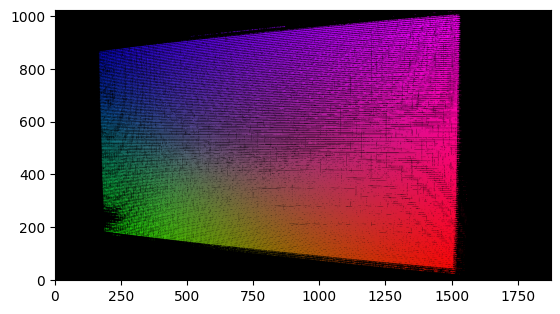

In [69]:
result_img = np.zeros((h_pixels.shape[0], h_pixels.shape[1], 3), dtype=int)

for i in range(h_pixels.shape[1]):
    for j in range(h_pixels.shape[0]):
        h_value = h_pixels[j, i]
        v_value = v_pixels[j, i]
        if h_value == -1 or v_value == -1:
            result_img[j, i] = [0, 0, 0]
        else:
            h_value = min(1919, h_value)
            v_value = min(1079, v_value)
            #print(h_value, v_value)
            result_img[j, i] = img[v_value, h_value]

plt.imshow(result_img, origin="lower")

# Show the plot
plt.show()


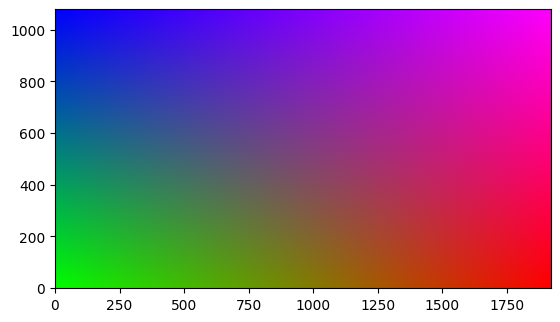

In [3]:
plt.imshow(img, origin="lower")

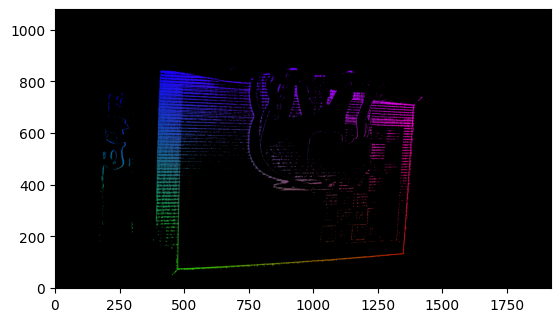

In [6]:
h_pixels = np.load('./data/h_pixel.npy')
v_pixels = np.load('./data/v_pixel.npy')

result_img = np.zeros((h_pixels.shape[0], h_pixels.shape[1], 3), dtype=int)

for i in range(h_pixels.shape[1]):
    for j in range(h_pixels.shape[0]):
        h_value = h_pixels[j, i]
        v_value = v_pixels[j, i]
        if h_value == -1 or v_value == -1:
            result_img[j, i] = [0, 0, 0]
        else:
            h_value = min(1919, h_value)
            v_value = min(1079, v_value)
            #print(h_value, v_value)
            result_img[j, i] = img[v_value, h_value]

plt.imshow(result_img, origin="lower")

# Show the plot
plt.show()